# Gambler's problem (Dynamic programming)

In [1]:
# Some useful libraries
import numpy as np
import matplotlib.pyplot as plt

## 1. Introduction and Setup

*(Based on Example 4.3 in Sutton & Barto)*

A gambler has the opportunity to make bets on the outcomes of a sequence of coin flips. If the coin comes up heads, he wins as many dollars as he has staked on that flip; if it is tails, he loses his stake.
The coin has a probability of $p_h = 0.4$ of coming up heads.
The player starts with some integer amount of money between $1 and $99.

The game ends when the gambler wins by reaching his goal of $100, or loses by running out of money.
On each flip, the gambler must decide what portion of his capital to stake, a positive integer number of dollars.
The player cannot cash out, he must play until he wins or loses.
Since there is only a total of $100 at the table, the gambler cannot place a bet that would cause him to have more than $100 after a win.
This problem can be formulated as an undiscounted, episodic, finite MDP. 

Identify the state-space, possible actions (per state), and reward/transition probabilities.

State-space: $ s \in S$ with
$$S = \{0, 1, ..., 100\} $$

Possible actions in state $s$: $a \in A(s)$ with
$$A(s) = \{1, ..., min(s, 100-s)\} $$

Rewards/transition probabilites:
$$ p(a+s, r|s, a) = 0.4 $$
$$ p(a-s, r|s, a) = 0.6 $$

If $s' = 100$, then $r = 1$, else $r = 0$.


Assign the values mentioned in the description to the constants below. (*Sidenote: in Python, there are no constants, but by convention, we use all caps for variables that are not supposed to be changed.*)

In [2]:
# Money goal to reach
MAX_MONEY = 100

# Possible values of probability of the coin coming up heads
P_HEADS =  0.3

# Small number determining the accuracy of policy evaluation's estimation
THETA = 1e-15

# Discount factor (can be 1, since this is an episodic task)
GAMMA = 1

# A list/array of all possible states
STATES = np.arange(MAX_MONEY + 1)

## 2. Policy Evaluation

In this section we evaluate a given deterministic policy $\pi$ by computing the state-value function $v_{\pi}$.

Define the policy you want to evaluate as an array `policy` of adequate length, where `policy[s]` is the action to take when the gambler's capital is `s`.

Initialize the value function as an array `values` of adequate length, where `values[s]` is the value of state `s`. Make sure that terminal states have value zero.

In [3]:
# Use length `MAX_MONEY + 1` to include the terminal state
policy = [min(s, MAX_MONEY - s, 20) for s in STATES]
values = np.zeros(MAX_MONEY + 1)

First, we implement a helper function that evaluates an action `a` for a given state `s`, using the current value function `currentValues`.

In [4]:
def evalAction(state, action, currentValues):
    # If we are already in a terminal state, return 0
    if state == 0 or state == MAX_MONEY:
        return 0
    
    # Check that s+a and s-a are valid states
    if state + action > MAX_MONEY or state - action < 0:
        raise ValueError("Invalid action")

    # Compute and return the expected reward + value of the next state
    expectedValue = P_HEADS * currentValues[state + action] + (1 - P_HEADS) * currentValues[state - action]
    
    if state + action == MAX_MONEY:
        expextedReward = P_HEADS
    else:
        expextedReward = 0

    return expextedReward + GAMMA * expectedValue
    

Implement iterative policy evaluation. You can follow the pseudo-code on page 75 in Sutton & Barto.

In [5]:
# Loop:
    # delta <- 0

    # Loop for each s in S:
        # v <- V(s)

        # V(s) <- sum_a ...
        # (this part might require multiple lines of code)

        # delta <- max(delta, |v - V(s)|)

    # until delta < THETA

In [6]:
while True:
    # Set delta to 0
    delta = 0
    
    # Update value function for each state
    for state in STATES:
        oldValue = values[state]

        action = policy[state]
        values[state] = evalAction(state, action, values)

        delta = max(delta, abs(oldValue - values[state]))
    
    # Break if delta is small enough
    if delta < THETA:
        break

Plot the value function you computed above.
Depending on your implementation, it might look nicer to ignore the terminal states (`0`, `MAX_MONEY`).

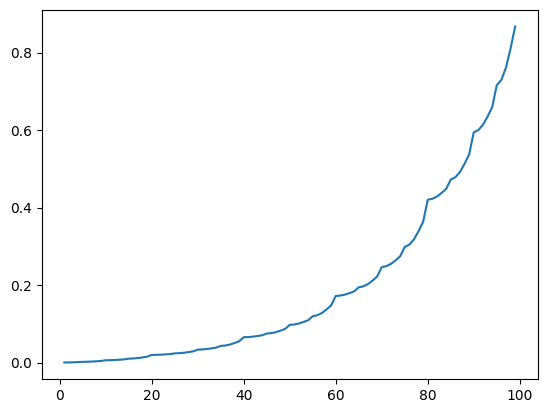

In [7]:
plt.figure()
plt.plot(STATES[1:-1], values[1:-1])
plt.show()

Does the value function look as expected?
How does the value function change for different policies, probabilities (`P_HEADS`), and discount factors (`GAMMA`)?

## 3. Policy Iteration

In this section, we compute the optimal policy and value function using policy iteration.
We implement the policy evaluation and improvement steps as individual functions, which we then call alternately for the actual policy iteration.



Implement the policy evaluation step. You can use your code from above, but need to wrap it in a function that takes the current policy as an argument.

In [8]:

def policyEvaluation(policy):
    # Initialize value function
    values = np.zeros(MAX_MONEY + 1)

    # (Same code as above)
    while True:
        # Set delta to 0
        delta = 0
        
        # Update value function for each state
        for state in STATES:
            oldValue = values[state]

            action = policy[state]
            values[state] = evalAction(state, action, values)

            delta = max(delta, abs(oldValue - values[state]))
        
        # Break if delta is small enough
        if delta < THETA:
            break
    # /(Same code as above)
    
    # Return the value function
    return values


Implement the policy improvement step as a function that takes the current value function as an argument and returns the new (greedy) policy.

*Note: In this particular example, there are multiple optimal policies. Your results might look nicer if you break ties (or almost ties) in favor of lower stakes.*

In [9]:
def policyImprovement(values):
    policy = []

    # Loop for each state
    for state in STATES:
        # If we are in a terminal state, do nothing (=0)
        if state == 0 or state == MAX_MONEY:
            policy.append(0)
            continue
        
        # Initialize best action and its value
        bestAction = 0
        bestValue = 0

        # Loop for each action
        actions = range(1, min(state, MAX_MONEY - state) + 1)
        for action in actions:
            # Compute the value of the action
            value = evalAction(state, action, values)

            # If the value is (significantly) better than the best value, update best value and best action
            # if value > bestValue:
            if value - bestValue > 2*THETA: # (avoid noisy updates)
                bestValue = value
                bestAction = action
        
        # Append best action to policy
        policy.append(bestAction)
    
    # Return the policy
    return policy

Implement policy iteration, using the functions you implemented above.

In [10]:
# Initialize values and policy
values = np.zeros(MAX_MONEY + 1)
policy = [1 for s in STATES]

# Do policy iteration
while True:
    # Policy evaluation
    values = policyEvaluation(policy)

    # Policy improvement
    newPolicy = policyImprovement(values)

    # Check if policy has changed
    if newPolicy == policy:
        break

    # Update policy
    policy = newPolicy
    

Plot the optimal value function and the optimal policy.

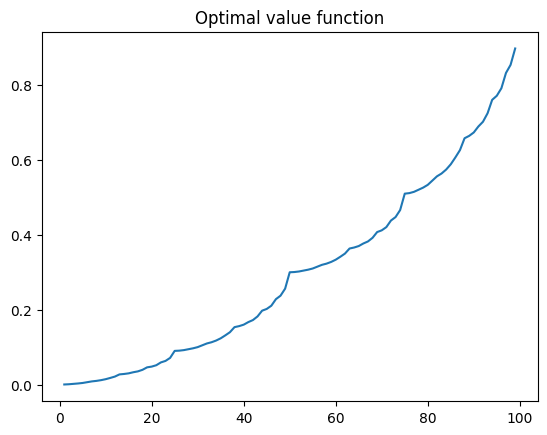

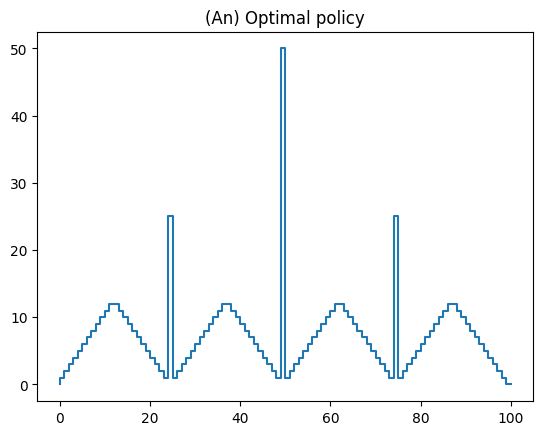

In [11]:
plt.figure()
plt.plot(STATES[1:-1], values[1:-1])
plt.title('Optimal value function')
plt.show()

plt.figure()
plt.step(STATES, policy)
plt.title('(An) Optimal policy')
plt.show()

## 4. Value Iteration

In this section we compute the optimal policy and value function using value iteration.
Again, we follow the pseudo-code from Sutton & Barto (p. 83).

In [12]:
# Initialize values

# Loop:
    # delta <- 0

    # Loop for each s in S:
        # v <- V(s)

        # V(s) <- max_a sum_s' ...
        # (this part might require multiple lines of code)

        # delta <- max(delta, |v - V(s)|)

    # until delta < THETA

# Output a deterministic policy such that
# policy[s] = argmax_a ...

In [13]:
# Initialize values to zero
values = np.zeros(MAX_MONEY + 1)

# Do value iteration
while True:
    delta = 0
    
    for state in STATES:
        oldValue = values[state]

        # Initialize best value
        newValue = 0

        # Loop for each action
        actions = range(1, min(state, MAX_MONEY - state) + 1)
        for action in actions:
            # Compute the value of the action
            value = evalAction(state, action, values)
            
            # Update newValue if better
            newValue = max(value, newValue)

        # Update value
        values[state] = newValue

        # Update delta
        delta = max(delta, abs(oldValue - newValue))
        
    if delta < THETA:
        break


In [18]:
# Initialize empty policy
policy = []

# Find best action for each state
for state in STATES:
    # If we are in a terminal state, do nothing (=0)
    if state == 0 or state == MAX_MONEY:
        policy.append(0)
        continue

    # Evaluate all actions
    actions = range(1, min(state, MAX_MONEY - state) + 1)
    actionValues = [evalAction(state, action, values) for action in actions]
    
    # Find the best action
    bestAction = actions[np.argmax(actionValues)]

    # Append best action to policy
    policy.append(bestAction)


In [23]:
# Or:
policy = policyImprovement(values)

Plot the optimal value function and the optimal policy.

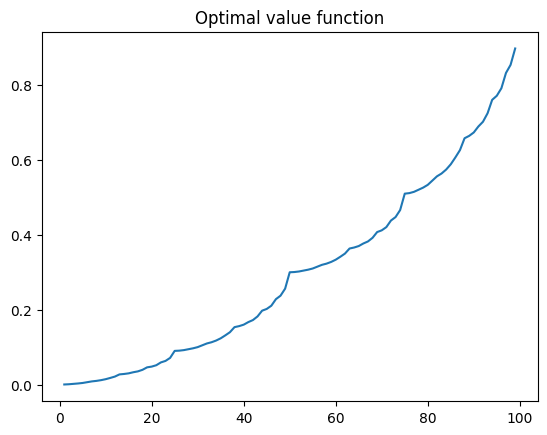

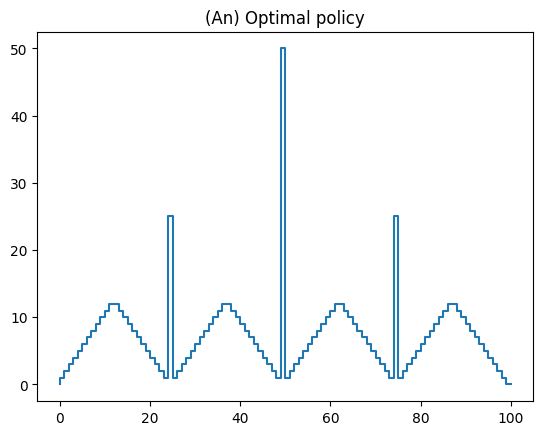

In [24]:
plt.figure()
plt.plot(STATES[1:-1], values[1:-1])
plt.title('Optimal value function')
plt.show()

plt.figure()
plt.step(STATES, policy)
plt.title('(An) Optimal policy')
plt.show()

### 4.a Bonus

Find and plot *all* optimal policies.

In [16]:
# Tolerance for "equal" values
TOL_OPTIMAL = 10 * THETA


# Initialize empty policy
# This time, this will be a list of lists
policy = []

# Loop for each state
for state in STATES:
    # If we are in a terminal state, do nothing
    if state == 0 or state == MAX_MONEY:
        policy.append([])
        continue

    # Evaluate all actions
    actions = range(1, min(state, MAX_MONEY - state) + 1)
    actionValues = [evalAction(state, action, values) for action in actions]
    
    # All optimal actions
    bestValue = np.max(actionValues)
    bestActions = [action for action, value in zip(actions, actionValues) if abs(value - bestValue) <= TOL_OPTIMAL]

    # Append best action to policy
    policy.append(bestActions)

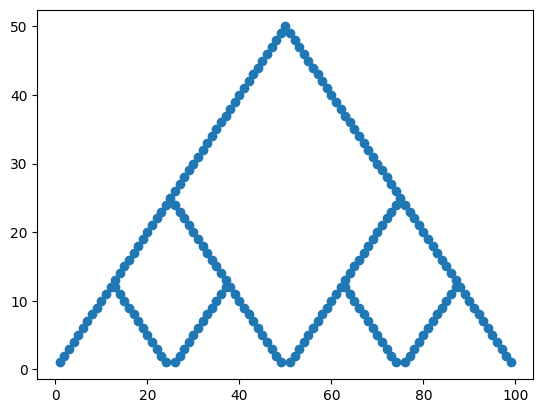

In [17]:
# Create scatter plot with all optimal state/action pairs
x = []
y = []

for state in STATES:
    for action in policy[state]:
        x.append(state)
        y.append(action)
        
plt.figure()
plt.scatter(x, y)
plt.show()


### 4.b Bonus 2

Ideas for further exploration:
- How does the set of *all* optimal policies behave for different values of `MAX_MONEY`? *Hint: Powers of 2 are particularly interesting!*
- Change the code above to allow bets which would cause the player to have more than $100 after a win. Does this change the optimal policy?
- Change the policy evaluation code to allow for non-deterministic policies.